# Movie Analysis

In [139]:
'''
 * @Author: Derick.Zhengkun Du 
 * @Date: 2022-03-16 15:43:16 
 * @Last Modified by:   Derick.Zhengkun Du 
 * @Last Modified time: 2022-03-16 15:43:16 
'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

from capstone_group4 import checkNone
from capstone_group4 import extData
from capstone_group4 import prof
from capstone_group4 import roi


## Data Extraction

In [140]:
user = 'zhengkundu'
key = '4a3a09239341e0a2cfac589c85df76a6'
filename = 'movies_metadata'
## use capstone_group4 function
movies_meta = extData(user, key, filename)

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  """


In [141]:
# movies_meta=pd.read_csv('movies_metadata.csv')#read the data
movies_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Data Cleaning

In [142]:
# Drop not usefull variables and dirty rows, assign a new dataframe to make word cloud
movies_meta = movies_meta[movies_meta['adult'].isin(['False','True'])]
movies_meta.drop(['belongs_to_collection', 'production_companies','spoken_languages','poster_path','homepage'], axis=1, inplace=True)
movies_meta.reset_index(drop=True, inplace=True)
movies_meta.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45463 non-null  object 
 1   budget                45463 non-null  object 
 2   genres                45463 non-null  object 
 3   id                    45463 non-null  object 
 4   imdb_id               45446 non-null  object 
 5   original_language     45452 non-null  object 
 6   original_title        45463 non-null  object 
 7   overview              44509 non-null  object 
 8   popularity            45460 non-null  object 
 9   production_countries  45460 non-null  object 
 10  release_date          45376 non-null  object 
 11  revenue               45460 non-null  float64
 12  runtime               45203 non-null  float64
 13  status                45379 non-null  object 
 14  tagline               20412 non-null  object 
 15  title              

In [143]:
# drop duplicated rows
dup_data = movies_meta.duplicated(keep = False)
movies_meta = movies_meta[~dup_data]

In [144]:
# Fill NA with mean or unknown
movies_meta['runtime'] = movies_meta['runtime'].fillna(value = pd.Series(movies_meta['runtime']).mean())
movies_meta['release_date'] = movies_meta['release_date'].fillna(value = pd.to_datetime(movies_meta['release_date']).mean())
movies_meta['status'] = movies_meta['status'].fillna("unknown")
movies_meta['original_language'] = movies_meta['original_language'].fillna(value = "en")
movies_meta['tagline'] = movies_meta['tagline'].fillna(value = " ")
movies_meta['overview'] = movies_meta['overview'].fillna(value = " ")
movies_meta['imdb_id'] = movies_meta['imdb_id'].fillna(value = " ")
movies_meta.isnull().sum()



adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              3
production_countries    3
release_date            0
revenue                 3
runtime                 0
status                  0
tagline                 0
title                   3
video                   3
vote_average            3
vote_count              3
dtype: int64

In [145]:
# remove the rows with NA value
movies_meta.dropna(axis = 0, how ='any', inplace = True)
movies_meta.reset_index(drop = True, inplace = True)
movies_meta.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
production_countries    0
release_date            0
revenue                 0
runtime                 0
status                  0
tagline                 0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [146]:
# turn to float type
floatvar = ('budget','popularity','revenue','runtime','vote_average','vote_count')
for i in floatvar:
    movies_meta[i] = movies_meta[i].astype(float)

In [147]:
# create profit and roi
movies_meta['profit'] = 0
movies_meta['profit'] = prof(movies_meta,rev='revenue',bug='budget',out='profit')
movies_meta['roi'] = 1.0
movies_meta['roi'] = roi(movies_meta,rev='revenue',bug='budget',out='roi')

c:\Users\70681\OneDrive - business\NEU\Study\ALY6140 Analytics Systems Technology\Group Project\capstone_group4.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out][i] = df[rev][i] - df[bug][i]
c:\Users\70681\OneDrive - business\NEU\Study\ALY6140 Analytics Systems Technology\Group Project\capstone_group4.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out][i] = 0
c:\Users\70681\OneDrive - business\NEU\Study\ALY6140 Analytics Systems Technology\Group Project\capstone_group4.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

In [148]:
movies_meta[movies_meta['profit'] == 0].count()

adult                   40074
budget                  40074
genres                  40074
id                      40074
imdb_id                 40074
original_language       40074
original_title          40074
overview                40074
popularity              40074
production_countries    40074
release_date            40074
revenue                 40074
runtime                 40074
status                  40074
tagline                 40074
title                   40074
video                   40074
vote_average            40074
vote_count              40074
profit                  40074
roi                     40074
dtype: int64

In [149]:
# create gain feature
movies_meta['gain'] = False
for i in range(movies_meta.shape[0]):
    if movies_meta['profit'][i] > 0:
        movies_meta['gain'][i] = True
    elif movies_meta['profit'][i] < 0:
        movies_meta['gain'][i] = False
    else: movies_meta['gain'][i] = 'unknown'



C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\JetBrains\Anaconda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [150]:
# Extract movie gneres from dictionary of column genres
movies_meta['genres_clean'] = movies_meta['genres'].fillna('[]').apply(literal_eval)
movies_meta['genres_clean'] = movies_meta['genres_clean'].apply(lambda x: [i['name'] for i in x])
movies_meta['genres_clean'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres_clean, dtype: object

In [151]:
# Extract movie countries from dictionary of column production_countries
movies_meta['country'] = movies_meta['production_countries'].fillna('[]').apply(literal_eval)
movies_meta['country'] = movies_meta['country'].apply(lambda x: [i['iso_3166_1'] for i in x] if isinstance(x, list) else None)
movies_meta['country'].tail()

45430    [IR]
45431    [PH]
45432    [US]
45433    [RU]
45434    [GB]
Name: country, dtype: object

In [152]:
movies_meta.reset_index(drop = True, inplace = True)
movies_meta_story = movies_meta[['title','overview','tagline']]

In [153]:
# select the first one country from list of country 
# it will takes 20 seconds, please wait

for i in range(len(movies_meta['country'])-1):
    if isinstance(movies_meta['country'][i],list):
        if checkNone(movies_meta['country'][i],None):
            movies_meta['production_countries'][i] = 'unknown'
        else: movies_meta['production_countries'][i] = movies_meta['country'][i][0]
    else: movies_meta['production_countries'][i] = 'unknown'
movies_meta['production_countries']


C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0                                                      US
1                                                      US
2                                                      US
3                                                      US
4                                                      US
                               ...                       
45430                                                  IR
45431                                                  PH
45432                                                  US
45433                                                  RU
45434    [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
Name: production_countries, Length: 45435, dtype: object

In [154]:
# movies_meta will be stacked by genres, movies_meta_unstack is the dataframe before stacking
movies_meta_unstack = movies_meta

In [155]:
# create stack of genres
# it will takes 20 seconds, please wait
movies_meta.drop(['genres'], axis=1, inplace=True)
g = (movies_meta['genres_clean'].apply(lambda x: pd.Series(list(x)))
                  .stack()
                  .rename('genres')
                  .reset_index(level=1, drop=True))
movies_meta = movies_meta.join(g).reset_index(drop=True)



C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [156]:
# drop unuseful variables
movies_meta.drop(['genres_clean','country','overview','tagline'], axis=1, inplace=True)
movies_meta.rename(columns={'production_countries': 'country'},inplace=True, errors='raise')

In [19]:
# Data cleaning process, all set! 
# please review in excel
# movies_meta.to_csv('test.csv',header=True)

In [121]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93465 entries, 0 to 93464
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              93465 non-null  object 
 1   budget             93465 non-null  float64
 2   id                 93465 non-null  object 
 3   imdb_id            93465 non-null  object 
 4   original_language  93465 non-null  object 
 5   country            93465 non-null  object 
 6   release_date       93465 non-null  object 
 7   revenue            93465 non-null  float64
 8   runtime            93465 non-null  float64
 9   status             93465 non-null  object 
 10  profit             93465 non-null  int64  
 11  roi                93465 non-null  float64
 12  gain               93465 non-null  object 
 13  genres             91023 non-null  object 
 14  is_english         93465 non-null  int64  
dtypes: float64(4), int64(2), object(9)
memory usage: 10.7+ MB


## Let's begin the EDA

In [20]:
# preparation for word cloud
movies_meta_story['overview'] = movies_meta_story['overview'].fillna(' ').replace('nan',' ').astype(str)
movies_meta_story['tagline'] = movies_meta_story['tagline'].fillna(' ').replace('nan',' ').astype(str)
movies_meta_story['title'] = movies_meta_story['title'].fillna(' ').replace('nan',' ').astype('str')
title = ' '.join( word for word in movies_meta_story['title'])
tagline = ' '.join(movies_meta_story['tagline'])
overview = ' '.join(movies_meta_story['overview'])


C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [21]:
import random
from PIL import Image
film_mask = np.array(Image.open('film_mask.jpg'))


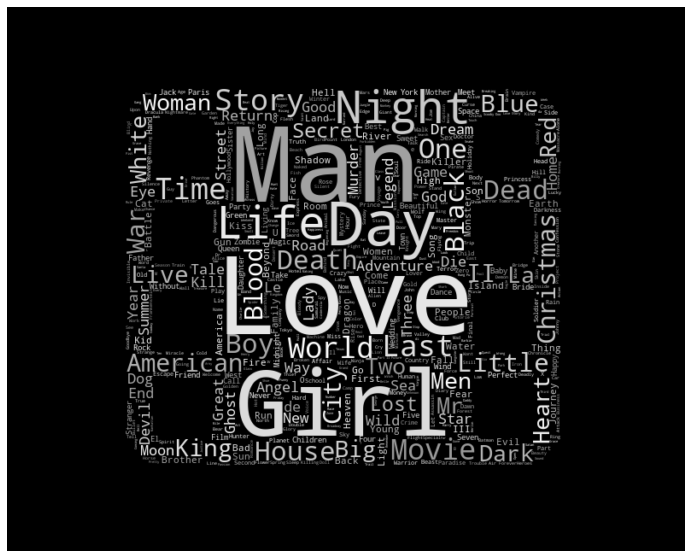

In [22]:
# word cloud for title
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

stopwords = set(STOPWORDS)
movie_wc = WordCloud(width=800, height=400,
    mask = film_mask,
    background_color = 'black',
    max_words=2000,
    stopwords = stopwords,
    max_font_size=200,
    random_state=60,
    # colormap = 'Blues'
    color_func = grey_color_func
   
)
movie_wc.generate(title)
plt.figure(figsize=(22,10))
plt.imshow(movie_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

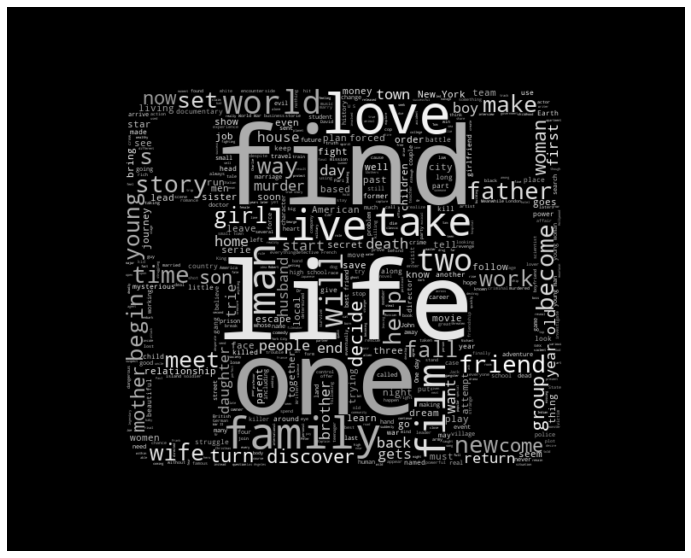

In [23]:
# word cloud for overview
stopwords = set(STOPWORDS)
movie_wc = WordCloud(width=800, height=400,
    mask = film_mask,
    background_color = 'black',
    max_words=2000,
    stopwords = stopwords,
    max_font_size=200,
    random_state=60,
    # colormap = 'Blues'
    color_func = grey_color_func
   
)
movie_wc.generate(overview)
plt.figure(figsize=(22,10))
plt.imshow(movie_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

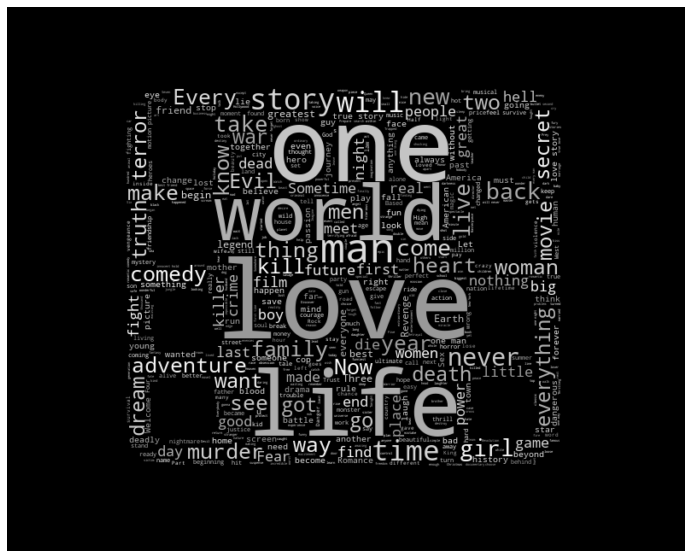

In [24]:
# word cloud for tagline
stopwords = set(STOPWORDS)
movie_wc = WordCloud(width=800, height=400,
    mask = film_mask,
    background_color = 'black',
    max_words=2000,
    stopwords = stopwords,
    max_font_size=200,
    random_state=60,
    # colormap = 'Blues'
    color_func = grey_color_func
   
)
movie_wc.generate(tagline)
plt.figure(figsize=(22,10))
plt.imshow(movie_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
floatvar = floatvar + ('profit',)

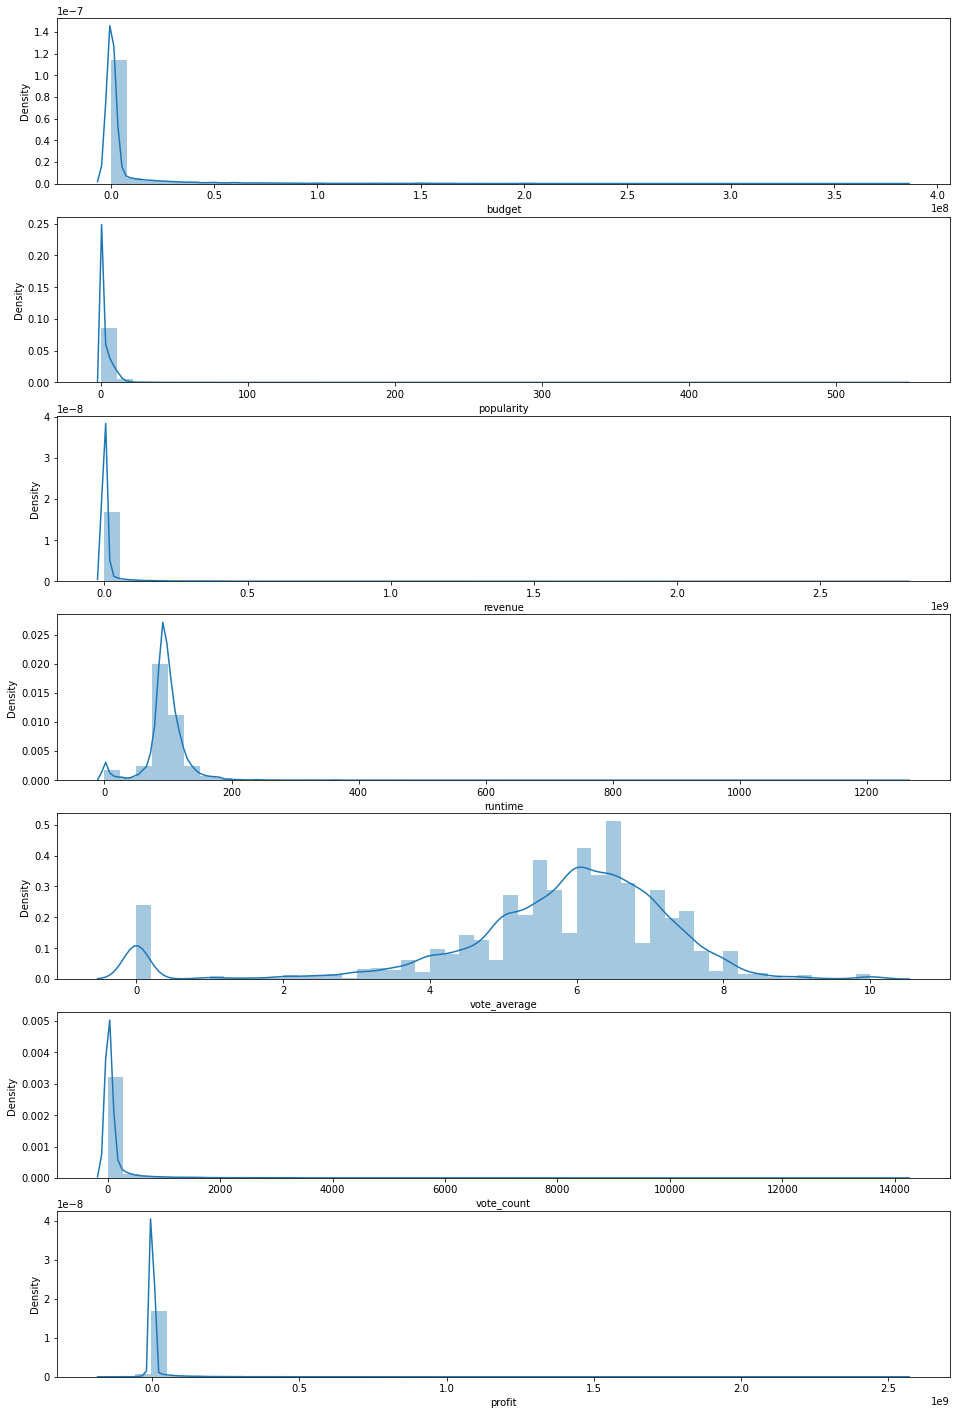

In [27]:
# Density plot of numerical data
fig, axes = plt.subplots(7, 1, figsize=(16, 25))
for i, d in zip(range(7), floatvar):
    sns.distplot(movies_meta[d], ax = axes[i])
# sns.distplot(movies_meta['budget'], ax= axes[0])
# sns.distplot(movies_meta['popularity'], ax= axes[1])
# sns.distplot(movies_meta['revenue'], ax= axes[2])
# sns.distplot(movies_meta['runtime'], ax= axes[3])
# sns.distplot(movies_meta['vote_average'], ax= axes[4])
# sns.distplot(movies_meta['vote_count'], ax= axes[5])



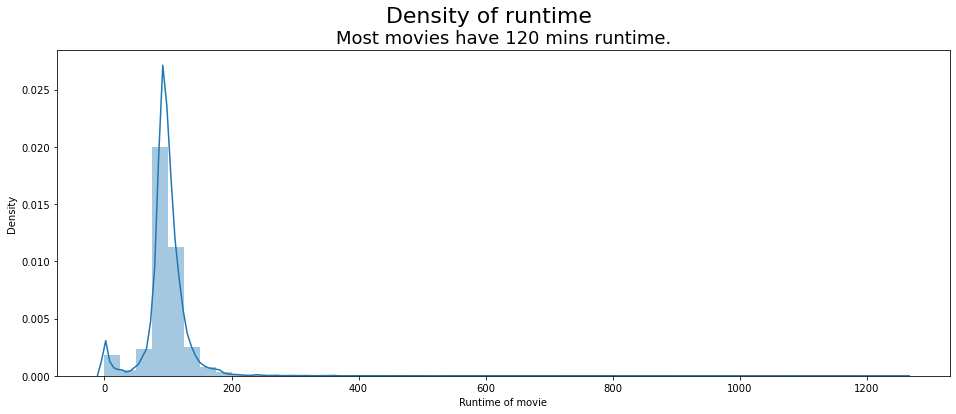

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['runtime'])
plt.xlabel('Runtime of movie') 

plt.title("Most movies have 120 mins runtime.", fontsize = 18)
plt.suptitle('Density of runtime', fontsize = 22)
plt.show()

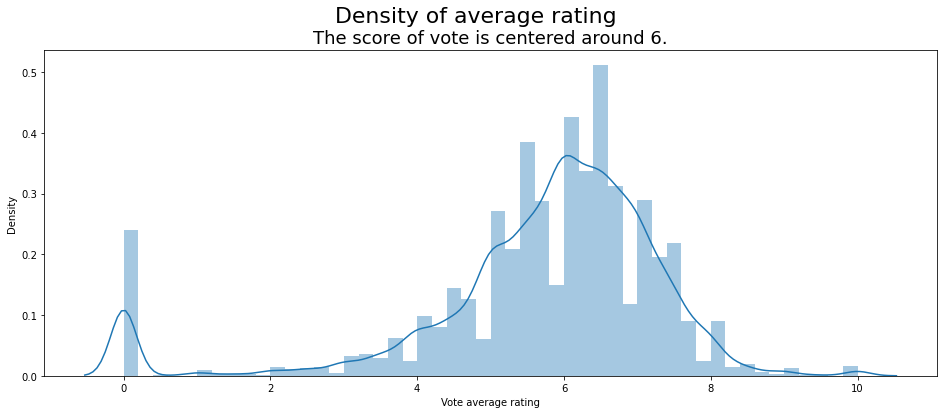

In [29]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['vote_average'])
plt.xlabel('Vote average rating') 

plt.title("The score of vote is centered around 6.", fontsize = 18)
plt.suptitle('Density of average rating', fontsize = 22)
plt.show()

(0.0, 20000000.0)

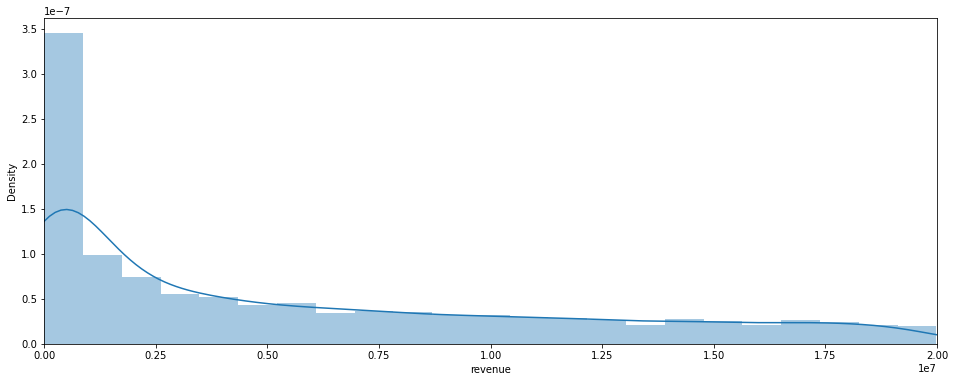

In [30]:
revenue_data = movies_meta[movies_meta['revenue'] < 20000000 ]
revenue_data = revenue_data[revenue_data['revenue'] != 0]
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(revenue_data['revenue'])
plt.xlim(0,20000000)

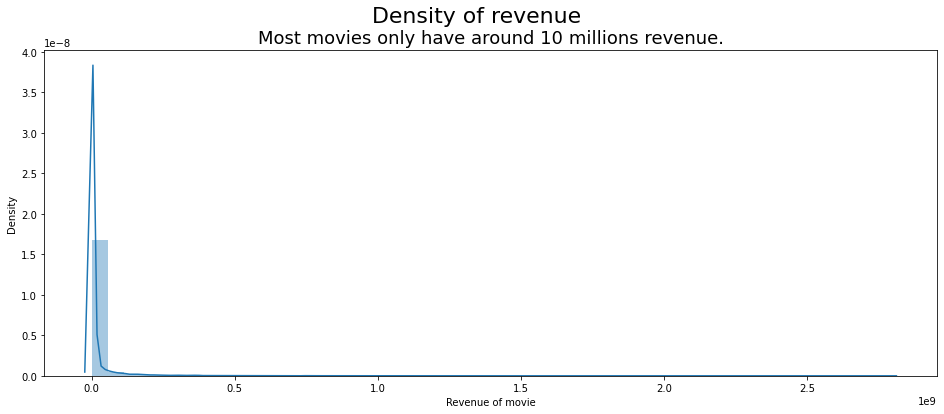

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['revenue'])
plt.xlabel('Revenue of movie') 

plt.title("Most movies only have around 10 millions revenue.", fontsize = 18)
plt.suptitle('Density of revenue', fontsize = 22)
plt.show()

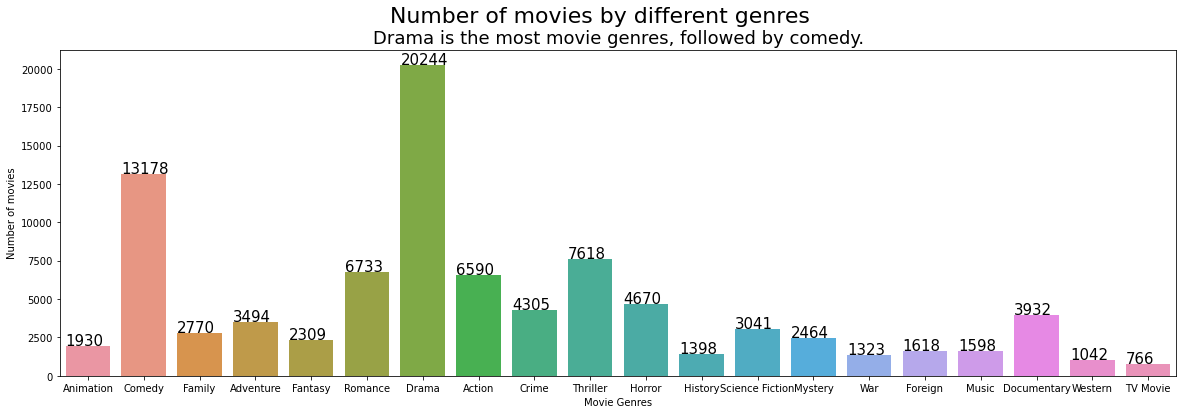

In [32]:
# One movie may have mutiple genres, so the sum of movies in this plot is not the same as the total numbers of movies.
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(data= movies_meta,x= 'genres' , ax =ax)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x(), p.get_height()+50), color='black', size=15)

plt.xlabel('Movie Genres') 
plt.ylabel('Number of movies') 
plt.title("Drama is the most movie genres, followed by comedy.", fontsize = 18)
plt.suptitle('Number of movies by different genres', fontsize = 22)
plt.show()

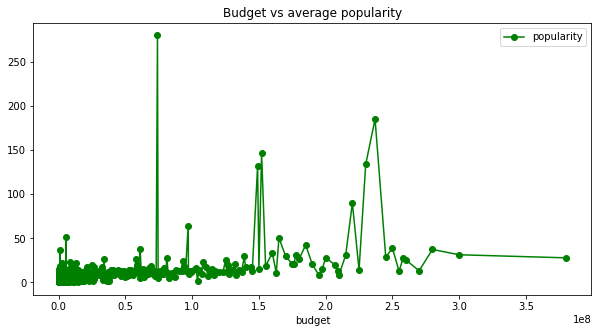

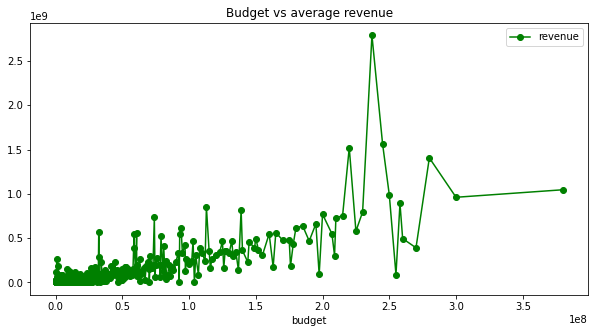

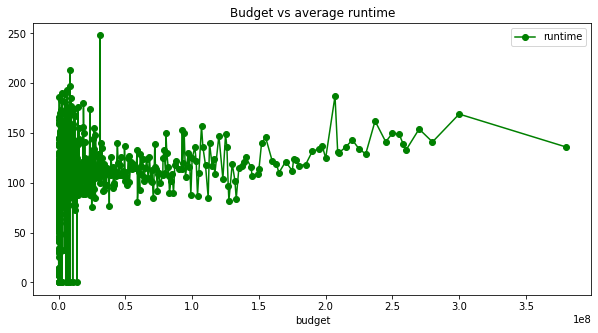

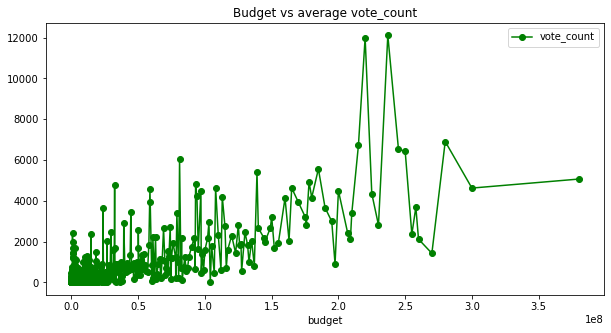

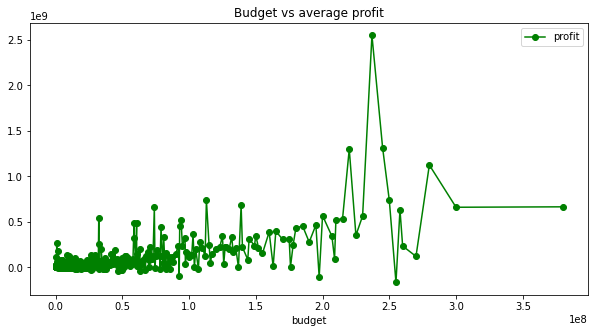

In [33]:
# scatter plot for average budget
for i in ('popularity','revenue','runtime','vote_count','profit'):
    axis = movies_meta.groupby('budget')[[i]].mean().plot(figsize=(10,5),marker='o',color='g')
    plt.title(f"Budget vs average {i}")

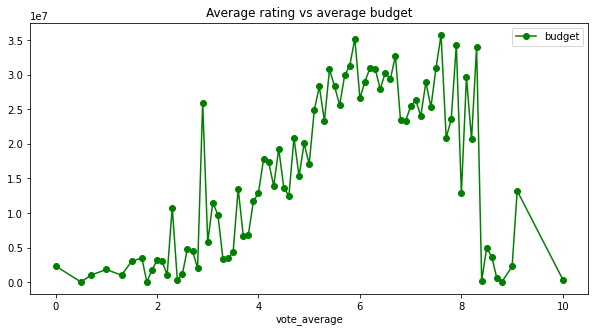

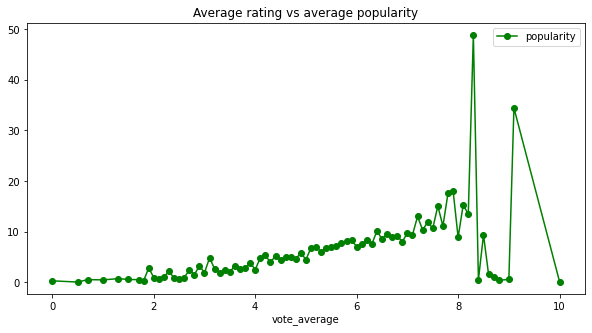

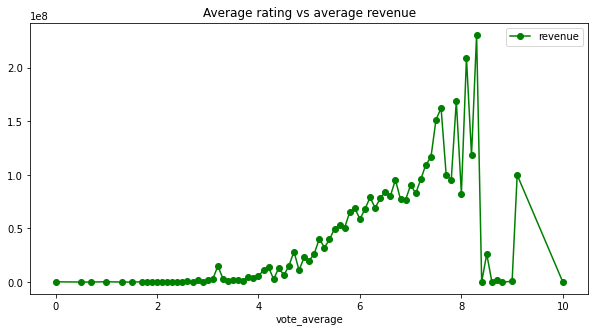

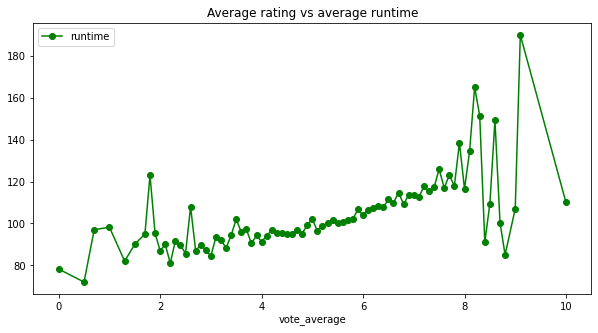

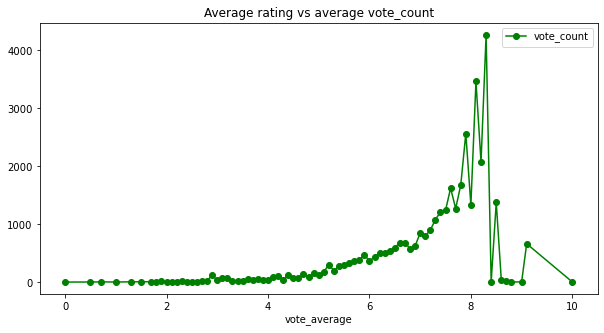

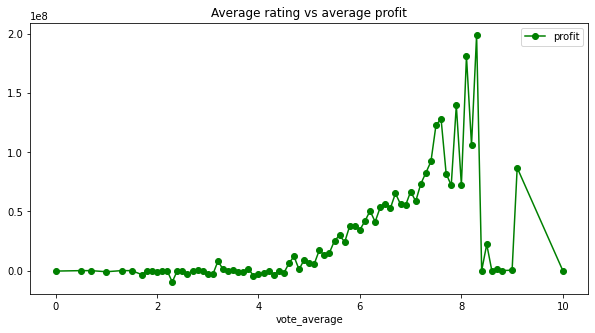

In [34]:
# scatter plot for average rating
plotdata = movies_meta[movies_meta['budget'] > 1000]
for i in ('budget','popularity','revenue','runtime','vote_count','profit'):
    axis = plotdata.groupby('vote_average')[[i]].mean().plot(figsize=(10,5),marker='o',color='g')
    plt.title(f"Average rating vs average {i}")

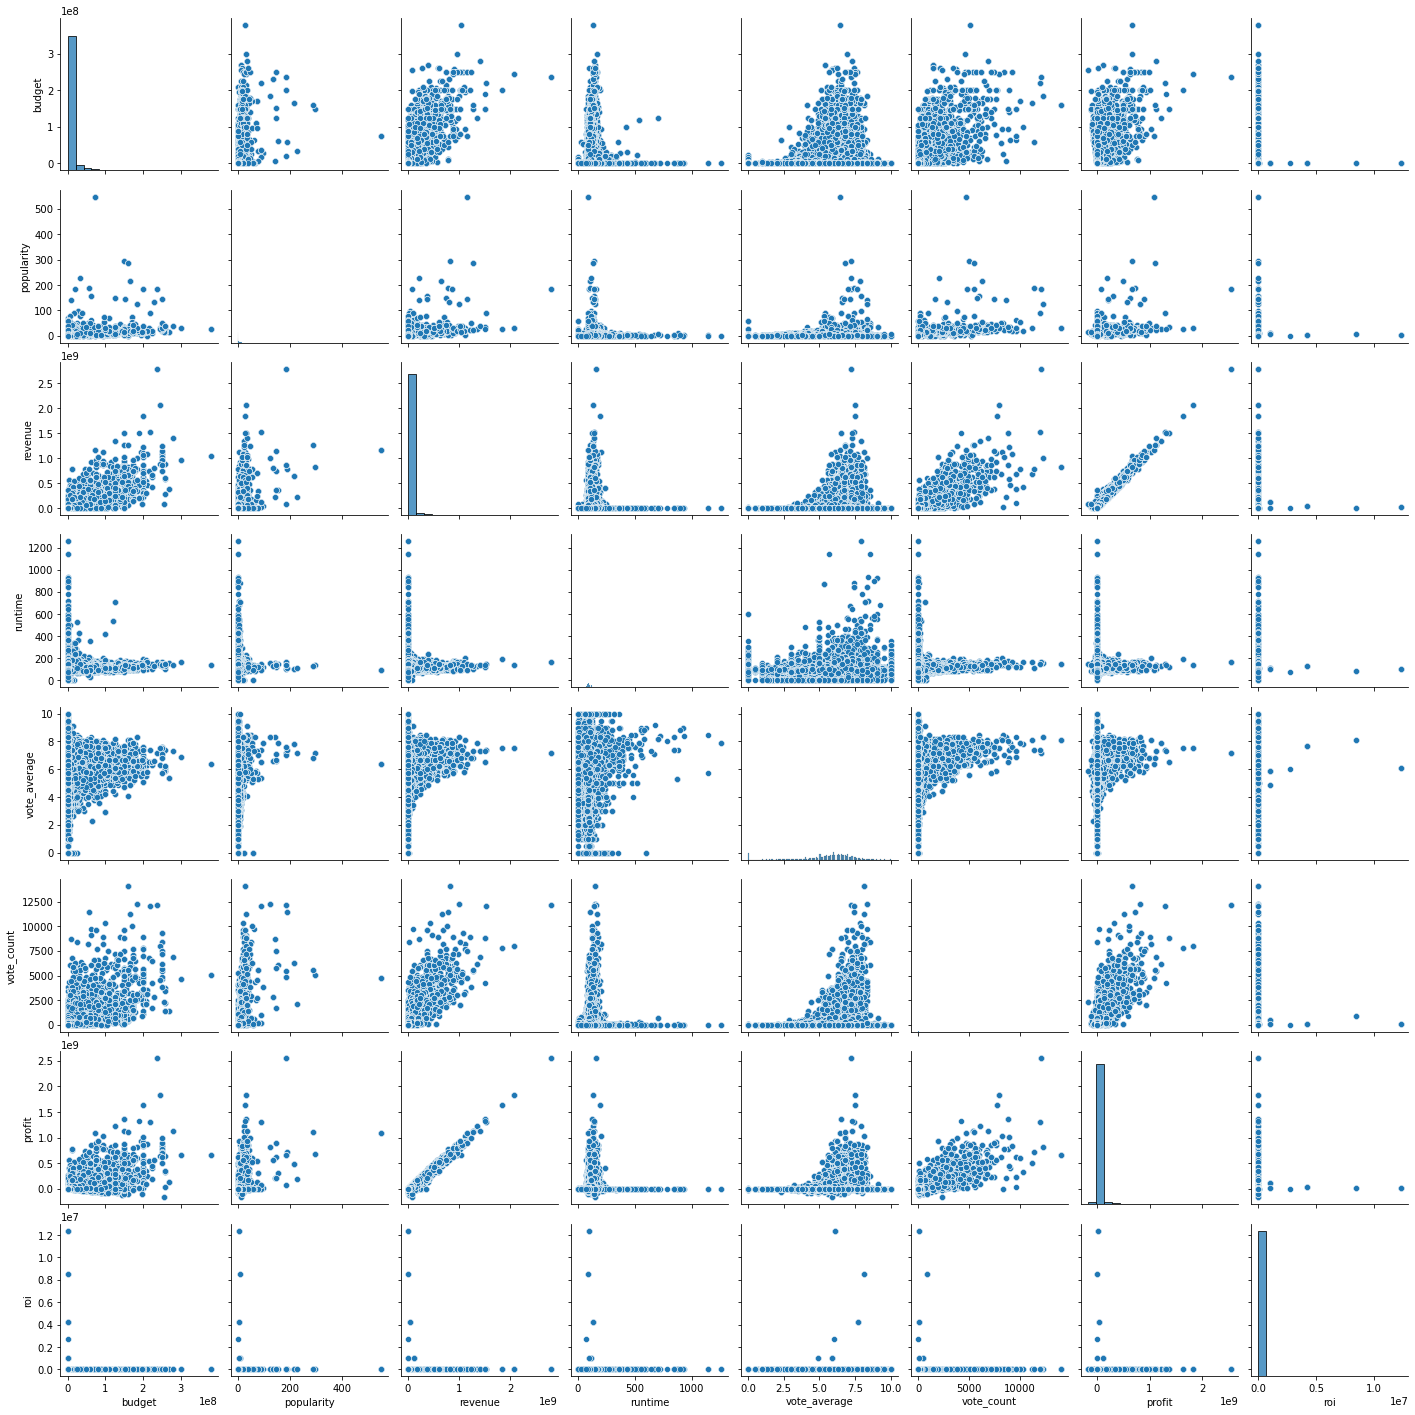

In [35]:
# pairplot
pairplotdata = movies_meta[['budget','popularity','revenue','runtime','vote_average','vote_count','profit','roi']]
sns.pairplot(data=pairplotdata)
plt.show()

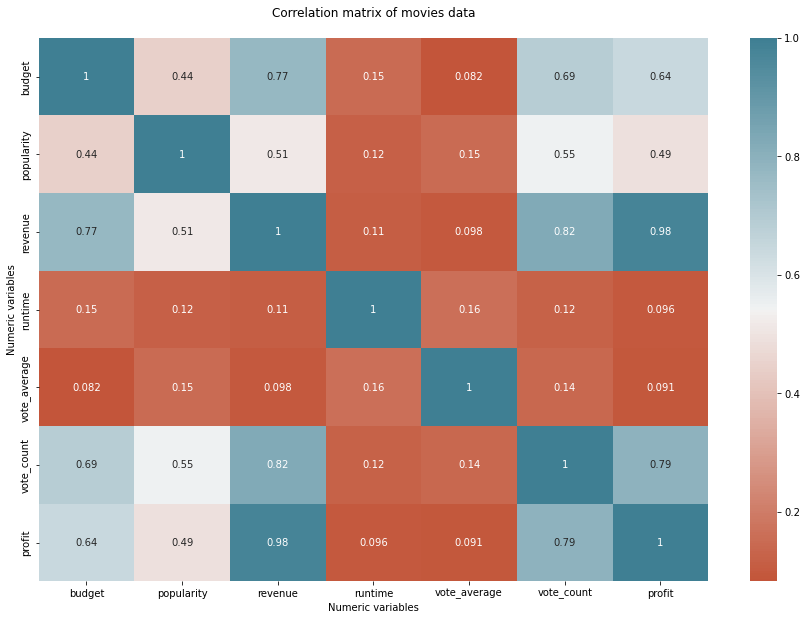

In [36]:
# correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
corrplot = sns.heatmap(movies_meta[['budget','popularity','revenue','runtime','vote_average','vote_count','profit']].corr(),
cmap=sns.diverging_palette(20, 220, n=200), annot = True)

corrplot.set(xlabel='Numeric variables', ylabel='Numeric variables', title = "Correlation matrix of movies data\n")

plt.show()

In [37]:
for i in range(movies_meta_unstack.shape[0]):
    if movies_meta_unstack['budget'][i] == movies_meta_unstack['revenue'][i] and movies_meta_unstack['budget'][i] != 0 and movies_meta_unstack['revenue'][i] != 0:
        print(i)
    

2545
11340
13858
15678
15905
23530
31449
33265
34508
35058
38239
38240
38241
38242
38243
38244
38245
38246
40651
43618


### Question 1

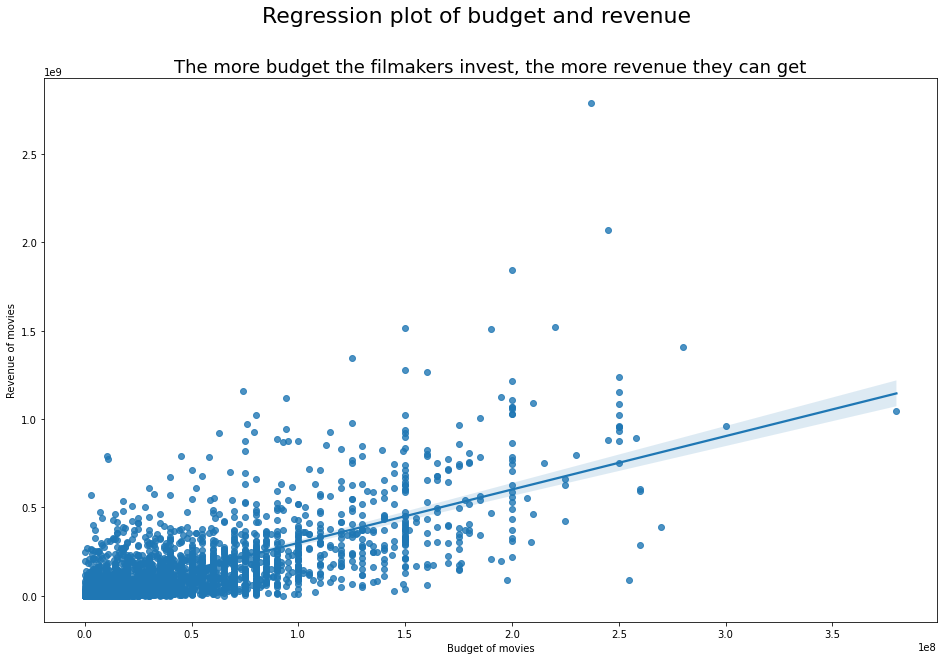

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6111.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:34:35   Log-Likelihood:            -1.0705e+05
No. Observations:                5361   AIC:                         2.141e+05
Df Residuals:                    5359   BIC:                         2.141e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.632e+06   1.97e+06     -1.847      0.0

In [38]:
# Question 1: We wanted to discover if a film's initial budget had an influence on its ultimate revenues and, 
# if so, what the impact trend was.
fig, ax = plt.subplots(figsize=(16, 10))
movies_budrev_regdata = movies_meta_unstack[movies_meta_unstack['profit'] != 0][['budget','revenue']]
x_budget = movies_budrev_regdata['budget']
y_revenue = movies_budrev_regdata['revenue']
sns.regplot(x=x_budget, y=y_revenue)
plt.xlabel('Budget of movies') 
plt.ylabel('Revenue of movies') 
plt.title("The more budget the filmakers invest, the more revenue they can get", fontsize = 18)
plt.suptitle('Regression plot of budget and revenue', fontsize = 22)
plt.show()

x_budget = sm.add_constant(x_budget)

#fit linear regression model
model = sm.OLS(y_revenue, x_budget).fit()

#view model summary
print(model.summary())


### Question 2

In [39]:
##Question 2 :  We want to know which movie genres are more likely to receive high ratings, so we can figure out what sort of movies the audience favored throughout the period covered by the dataset.
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
movies1 = movies_meta[movies_meta['vote_count'] != 0]
df1 = movies1.groupby('genres')['vote_average'].mean().sort_values()
df1 = df1.to_frame()
df1.reset_index(drop = False, inplace = True)
df1

,genres,vote_average
0,Horror,5.311242
1,Science Fiction,5.466375
2,TV Movie,5.641350
3,Western,5.709650
4,Thriller,5.733088
5,Action,5.745418
6,Adventure,5.872273
7,Fantasy,5.919558
8,Family,5.933321
9,Mystery,5.959684


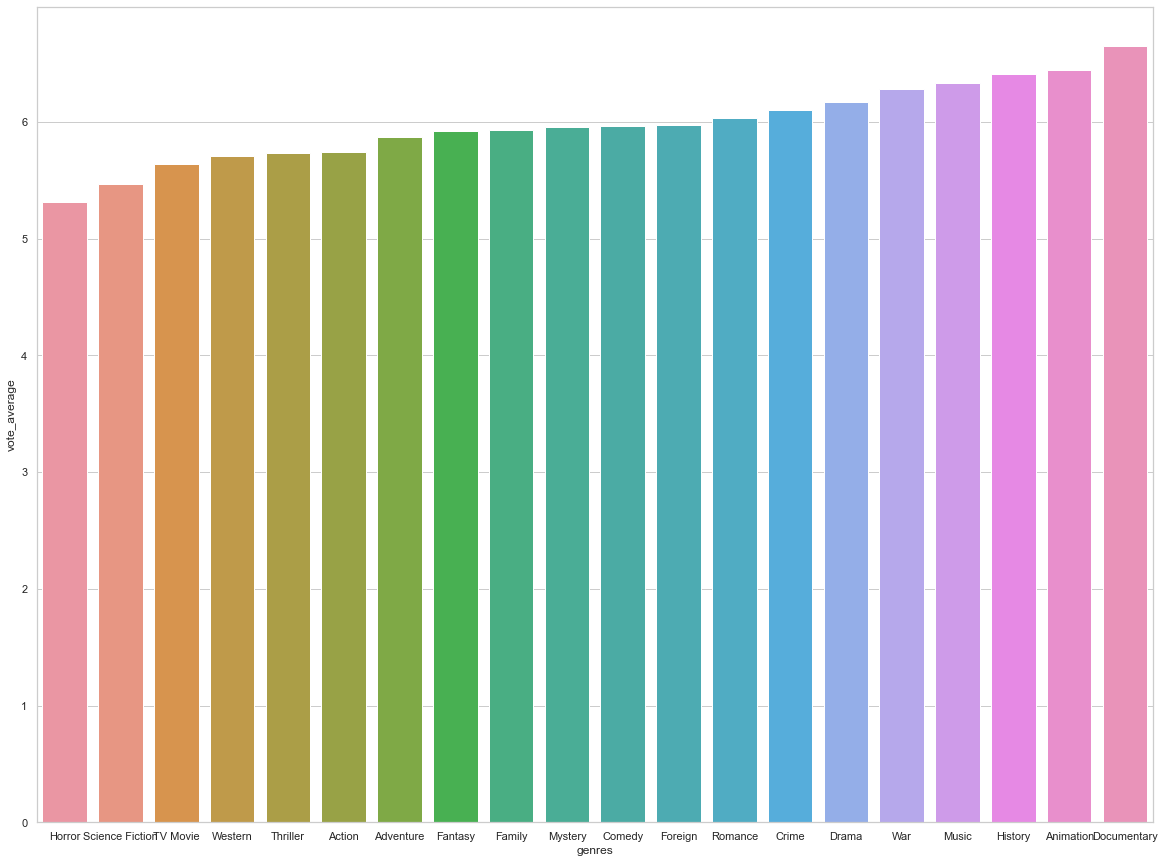

In [40]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="vote_average", data=df1)
plt.show()

### Question 3

In [41]:

##Question 3 : Are there substantial differences between English-language films and those in other languages in certain variables? Can we determine a film's linguistic kind based on these differences?sssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaAAssssssssssssssssssssssssssssssssssssssssssssssssssssssxxxzz                 ddddddaaaasdasaasx                                  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxxxxxzzzzz
movies_meta_unstack['month'] = movies_meta_unstack.release_date.str.split('-',2).str[1]
movies_meta_unstack['year'] = movies_meta_unstack.release_date.str.split('-',2).str[0]
movies_meta_unstack['month'].isna().sum()
movies_meta_unstack.dropna(axis = 0, how ='any', inplace = True)
movies_meta_unstack['month'].isna().sum()

0

In [42]:
# extract month year
movies_meta['month'] = movies_meta.release_date.str.split('-',2).str[1]
movies_meta['year'] = movies_meta.release_date.str.split('-',2).str[0]
movies_meta['month'].isna().sum()
movies_meta.dropna(axis = 0, how ='any', inplace = True)

In [43]:
movies_meta_unstack['isen'] = ""
movies_meta_unstack.loc[movies_meta_unstack['original_language']=='en',"isen"] = "Yes"
movies_meta_unstack.loc[movies_meta_unstack['original_language']!='en',"isen"] = "No"
movies_meta_unstack

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,production_countries,release_date,...,vote_average,vote_count,profit,roi,gain,genres_clean,country,month,year,isen
0,False,30000000.0,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,US,1995-10-30,...,7.7,5415.0,343554033,11.451801,True,"[Animation, Comedy, Family]",[US],10,1995,Yes
1,False,65000000.0,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,US,1995-12-15,...,6.9,2413.0,197797249,3.043035,True,"[Adventure, Fantasy, Family]",[US],12,1995,Yes
2,False,0.0,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,US,1995-12-22,...,6.5,92.0,0,0.000000,unknown,"[Romance, Comedy]",[US],12,1995,Yes
3,False,16000000.0,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,US,1995-12-22,...,6.1,34.0,65452156,4.090760,True,"[Comedy, Drama, Romance]",[US],12,1995,Yes
4,False,0.0,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,US,1995-02-10,...,5.7,173.0,0,0.000000,unknown,[Comedy],[US],02,1995,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45429,False,0.0,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,CA,1991-05-13,...,5.7,26.0,0,0.000000,unknown,"[Drama, Action, Romance]","[CA, DE, GB, US]",05,1991,Yes
45431,False,0.0,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,PH,2011-11-17,...,9.0,3.0,0,0.000000,unknown,[Drama],[PH],11,2011,No
45432,False,0.0,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,US,2003-08-01,...,3.8,6.0,0,0.000000,unknown,"[Action, Drama, Thriller]",[US],08,2003,Yes
45433,False,0.0,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,RU,1917-10-21,...,0.0,0.0,0,0.000000,unknown,[],[RU],10,1917,Yes


In [44]:
movies_meta_unstack.groupby('isen').agg({'budget':['max','min','mean'],
                                         'revenue':['max','min','mean'],
                                         'profit':['max','min','mean'],
                                         'runtime':['max','min','mean'],
                                         'vote_average':['mean'],
                                         'vote_count':['mean']})
                                


budget                          revenue                     \
              max  min          mean           max  min          mean   
isen                                                                    
No    150000000.0  0.0  8.398865e+05  4.264809e+08  0.0  1.522545e+06   
Yes   380000000.0  0.0  5.621619e+06  2.787965e+09  0.0  1.520393e+07   

          profit                          runtime                  \
             max        min          mean     max  min       mean   
isen                                                                
No     413480871  -91969578  7.413806e+05   931.0  0.0  96.588297   
Yes   2550965087 -165710090  9.594400e+06  1256.0  0.0  93.188845   

     vote_average  vote_count  
             mean        mean  
isen                           
No       5.936283   32.499544  
Yes      5.496559  141.847542

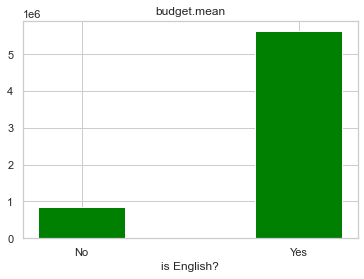

In [45]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[8.401420e+05	,5.623334e+06]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("budget.mean")
plt.show() 

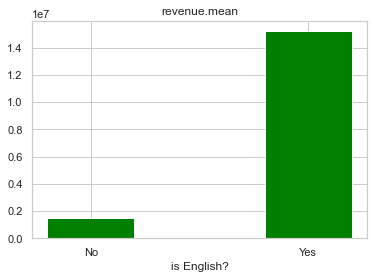

In [46]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[1.523008e+06,1.520866e+07]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("revenue.mean")
plt.show()

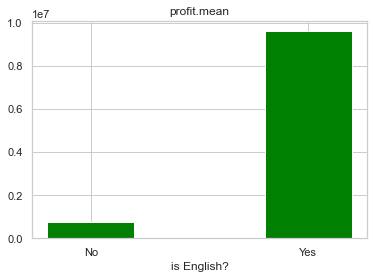

In [47]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[7.416062e+05,9.597381e+06]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("profit.mean")
plt.show()

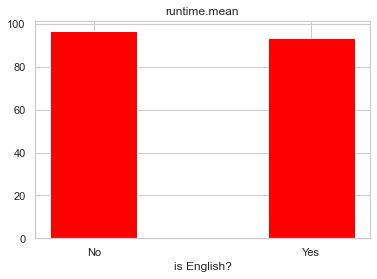

In [48]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[96.584122,93.199062]
fig = plt.figure()
plt.bar(X,Y,0.4,color="red")
plt.xlabel("is English?")
plt.title("runtime.mean")
plt.show()

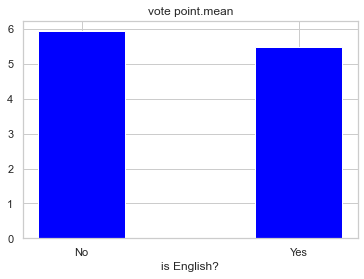

In [49]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[5.936584,5.497055]
fig = plt.figure()
plt.bar(X,Y,0.4,color="blue")
plt.xlabel("is English?")
plt.title("vote point.mean")
plt.show()

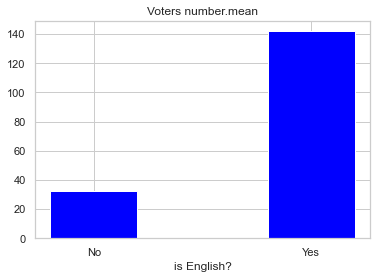

In [50]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[32.508671,141.888378]
fig = plt.figure()
plt.bar(X,Y,0.4,color="blue")
plt.xlabel("is English?")
plt.title("Voters number.mean")
plt.show()

In [51]:
movies_meta['isen'] = ""
movies_meta.loc[movies_meta['original_language']=='en',"isen"] = "Yes"
movies_meta.loc[movies_meta['original_language']!='en',"isen"] = "No"
movies_meta
dddd = movies_meta['genres'].groupby(movies_meta['isen']).value_counts()
dddd
dddd = pd.DataFrame(dddd)
column = dddd.columns.to_list()
column[0]='count'
dddd.columns = column
dddd.reset_index(drop = False, inplace = True)
d1 = dddd.iloc[0:20]
d2 = dddd.iloc[20:40]
dddd

,isen,genres,count
0,No,Drama,7016
1,No,Comedy,3865
2,No,Romance,1911
3,No,Action,1864
4,No,Thriller,1632
5,No,Crime,1149
6,No,Foreign,932
7,No,Horror,880
8,No,Adventure,816
9,No,Fantasy,721


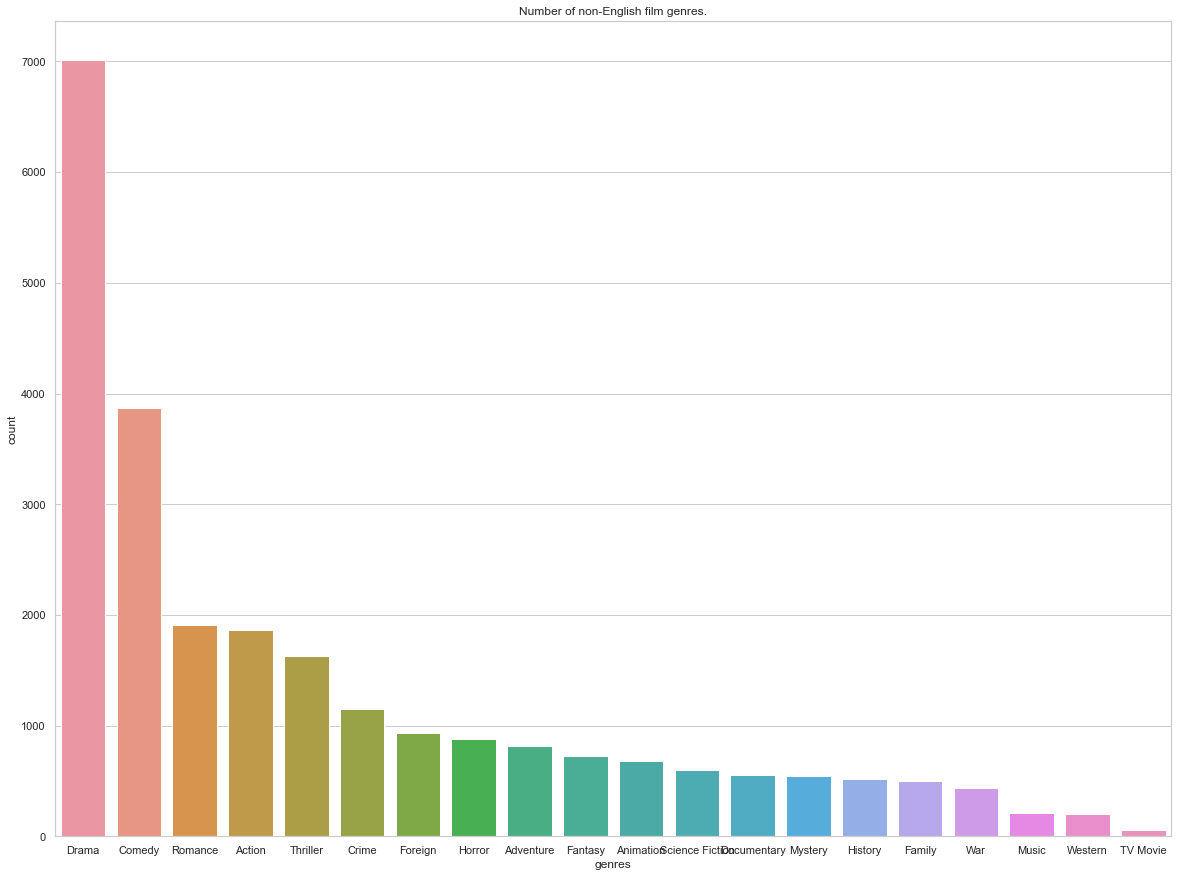

In [52]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="count", data=d1)
plt.title("Number of non-English film genres.")
plt.show()

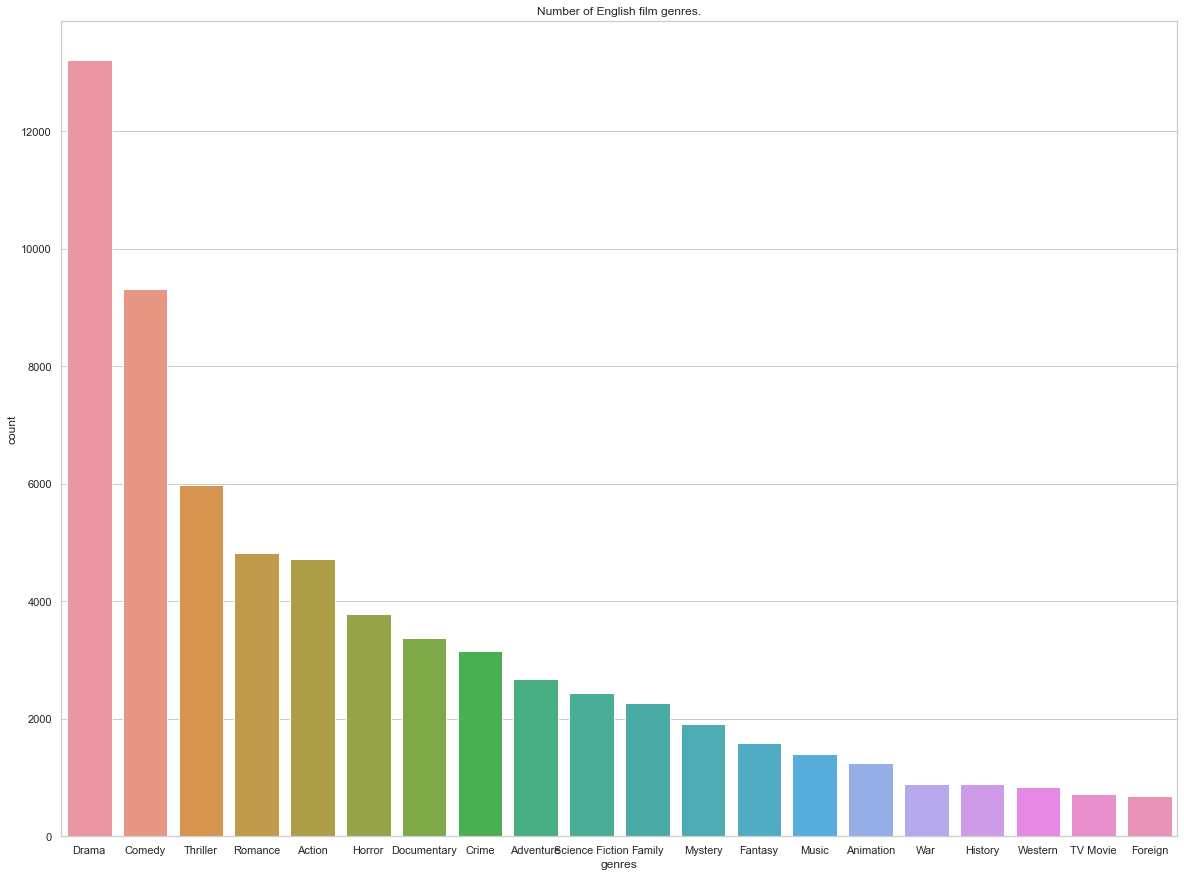

In [53]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="count", data=d2)
plt.title("Number of English film genres.")
plt.show()

In [54]:
movies_meta_unstack['adult'].groupby(movies_meta_unstack['isen']).value_counts()

isen  adult
No    False    13148
      True         4
Yes   False    32195
      True         4
Name: adult, dtype: int64

In [55]:
movies_meta_unstack['month'].groupby(movies_meta_unstack['isen']).value_counts().sort_values()

isen  month
No    07        631
      06        787
      04        926
      05        929
      08        986
      02       1008
      03       1041
      11       1082
      12       1191
      10       1338
      09       1494
      01       1739
Yes   07       2009
      02       2018
      06       2364
      05       2408
      08       2408
      03       2512
      04       2527
      11       2579
      12       2592
      10       3273
      09       3340
      01       4169
Name: month, dtype: int64

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  after removing the cwd from sys.path.


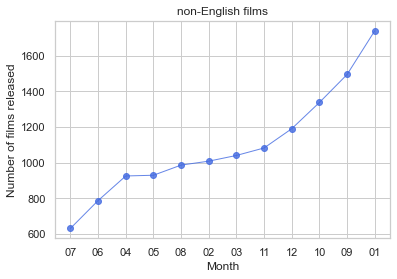

In [56]:
X=['07','06','04','05','08','02','03','11','12','10','09','01']
Y=[631,787,925,929,986,1008,1040,1082,1190,1337,1494,1739]  
fig = plt.figure()
plt.plot(X, Y, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='一些数字')
plt.xlabel("Month")
plt.ylabel("Number of films released")
plt.title("non-English films")
plt.show() 

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  after removing the cwd from sys.path.


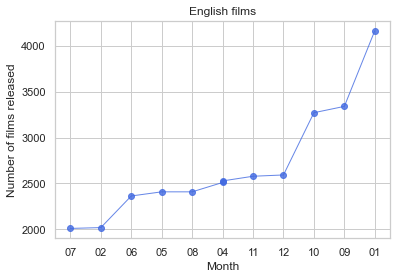

In [57]:
X=['07','02','06','05','08','04','04','11','12','10','09','01']
Y=[2009,2018,2363,2408,2408,2510,2527,2578,2592,3271,3340,4165]  
fig = plt.figure()
plt.plot(X, Y, 'ro-', color='#4169E1', alpha=0.8, linewidth=1)
plt.xlabel("Month")
plt.ylabel("Number of films released")
plt.title("English films")
plt.show() 

In [58]:
movies_meta_unstack['year'].groupby(movies_meta_unstack['isen']).value_counts().sort_values(ascending=False)

isen  year
Yes   2014    1385
      2013    1318
      2015    1277
      2012    1200
      2011    1132
              ... 
No    1874       1
      1887       1
      1892       1
      1893       1
Yes   2020       1
Name: year, Length: 261, dtype: int64

### Question 3

<AxesSubplot:title={'center':'Number of Movies Released each Month'}, xlabel='release_month'>

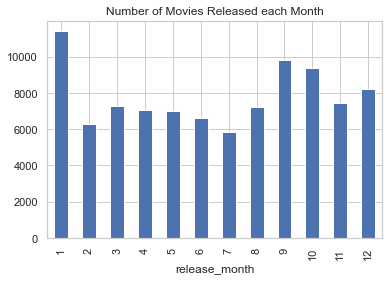

In [122]:
# Number of Movies Released each Month
movies_meta['release_date'] = pd.to_datetime(movies_meta['release_date'], format ='%Y-%m-%d')
movies_meta['release_month']=pd.DatetimeIndex(movies_meta['release_date']).month
# In which month of the year will the most films be released?
month_stat = movies_meta.groupby("release_month").size()
month_stat.plot(y = "number",kind = "bar",title= "Number of Movies Released each Month")

array([<AxesSubplot:title={'center':'budget'}, xlabel='release_month'>,
       <AxesSubplot:title={'center':'revenue'}, xlabel='release_month'>,
       <AxesSubplot:title={'center':'vote_average'}, xlabel='release_month'>],
      dtype=object)

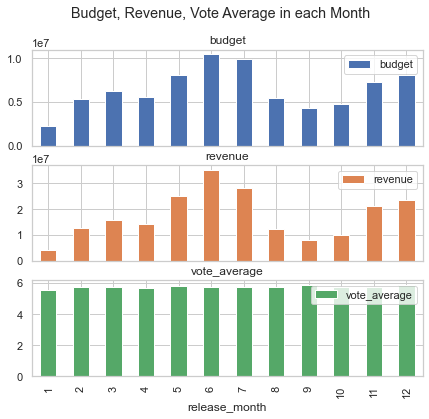

In [61]:
movies_meta['budget']= movies_meta['budget'].apply(pd.to_numeric)
# changes in budget
# changes in revenue
# changes in vote average
month_avg = movies_meta.groupby("release_month").agg({'budget':'mean','revenue':'mean','vote_average':'mean'})
month_avg
month_avg.plot(subplots = True,kind = "bar",figsize=(7,6),title = "Budget, Revenue, Vote Average in each Month")

## Model

#### Model 1: In order to figure out what features or variables have significant impact on the popularity, we need to make a regression model to predict the popularity of movies. There is no question that this model is considerable and beneficial to filmmakers.

In [70]:
# Model 1: In order to figure out what features or variables have significant impact on the popularity, 
# we need to make a regression model to predict the popularity of movies. 
# There is no question that this model is considerable and beneficial to filmmakers.
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

In [66]:
# choose budget greater than 1000
model1_data = movies_meta[['budget','popularity','runtime','vote_average','release_date','country','original_language','genres']]
model1_data = model1_data[model1_data['budget']>1000]
model1_data.release_date = model1_data.release_date.astype(str)
model1_data['month'] = model1_data.release_date.str.split('-',2).str[1].astype(str)
model1_data['month'].isna().sum()
model1_data.dropna(axis = 0, how ='any', inplace = True)

model1_data.reset_index(drop=True, inplace=True)
model1_data['month'].head()


0    10
1    10
2    10
3    12
4    12
Name: month, dtype: object

In [67]:
# choose only four language and country
main_lang = ('en','ja','fr','es')
for i in range(model1_data.shape[0]):
    if model1_data['original_language'][i] not in main_lang:
        model1_data['original_language'][i] = 'other'

main_con = ('US','GB','CA','DE')
for i in range(model1_data.shape[0]):
    if model1_data['country'][i] not in main_con:
        model1_data['country'][i] = 'other'

model1_data['is_holiday'] = model1_data['month'].apply(lambda x: 'Yes' if x in ['1', '11','4', '5', '6','9', '12'] else 'No').astype('str')
model1_data.drop(['release_date','month'], axis=1, inplace=True)

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [68]:
model1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21320 entries, 0 to 21319
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             21320 non-null  float64
 1   popularity         21320 non-null  float64
 2   runtime            21320 non-null  float64
 3   vote_average       21320 non-null  float64
 4   country            21320 non-null  object 
 5   original_language  21320 non-null  object 
 6   genres             21320 non-null  object 
 7   is_holiday         21320 non-null  object 
dtypes: float64(4), object(4)
memory usage: 1.3+ MB


In [177]:
# split train and test data
X, y = model1_data.drop('popularity', axis=1), model1_data['popularity']
X= pd.get_dummies(X,prefix='',prefix_sep='')
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2)



In [72]:
# sns.regplot(x=train_X, y=train_y)

# x_budget = sm.add_constant(x_budget)

#fit linear regression model
model = sm.OLS(train_y, train_X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     99.69
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:42:05   Log-Likelihood:                -62355.
No. Observations:               15990   AIC:                         1.248e+05
Df Residuals:                   15958   BIC:                         1.250e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
budget           1.088e-07   2.76e-09     

In [178]:
# standardization
# Lasso performs best when all numerical features are centered around 0 and have variance in the same order
from sklearn.preprocessing import StandardScaler
list_numeric = ['budget','runtime','vote_average']
scaler = StandardScaler().fit(train_X[list_numeric]) 

train_X[list_numeric] = scaler.transform(train_X[list_numeric])

test_X[list_numeric] = scaler.transform(test_X[list_numeric])

In [179]:
# lasso regression iteration 2000000000
lasscv = LassoCV(cv =10, random_state=0,max_iter = 2000000000)
lasscv.fit(train_X, train_y)

LassoCV(cv=10, max_iter=2000000000, random_state=0)

In [180]:
alpha = lasscv.alpha_
alpha

0.00445915392272752

In [181]:
# use lasso best alpha to fit
lasso_best = Lasso(alpha=alpha)
lasso_best.fit(train_X, train_y)

Lasso(alpha=0.00445915392272752)

In [182]:
print(list(zip(lasso_best.coef_, X)))


[(3.9546170893920944, 'budget'), (0.11827451076058892, 'runtime'), (2.074926180928292, 'vote_average'), (0.0, 'CA'), (-0.8172388845897859, 'DE'), (0.46584497051178453, 'GB'), (0.2521172683103805, 'US'), (-0.9455414501473814, 'other'), (0.7683059777049905, 'en'), (0.0, 'es'), (-0.0, 'fr'), (0.0, 'ja'), (-1.546143171158386, 'other'), (0.7788640484887989, 'Action'), (1.2257132765830285, 'Adventure'), (0.9052993898299262, 'Animation'), (-0.007936964450802653, 'Comedy'), (0.04929812539040008, 'Crime'), (-2.6794849015430193, 'Documentary'), (-0.38775155591309524, 'Drama'), (-0.0, 'Family'), (0.7468177055473023, 'Fantasy'), (-1.766450494023169, 'Foreign'), (-0.9352371552743561, 'History'), (1.2603679151093716, 'Horror'), (-0.9739512439115013, 'Music'), (0.46670898893776697, 'Mystery'), (-0.347253004022127, 'Romance'), (0.8890415270893008, 'Science Fiction'), (-0.0, 'TV Movie'), (0.8562545101970931, 'Thriller'), (-0.09586786203181985, 'War'), (-0.0, 'Western'), (0.7231480201583251, 'No'), (-0.

<AxesSubplot:>

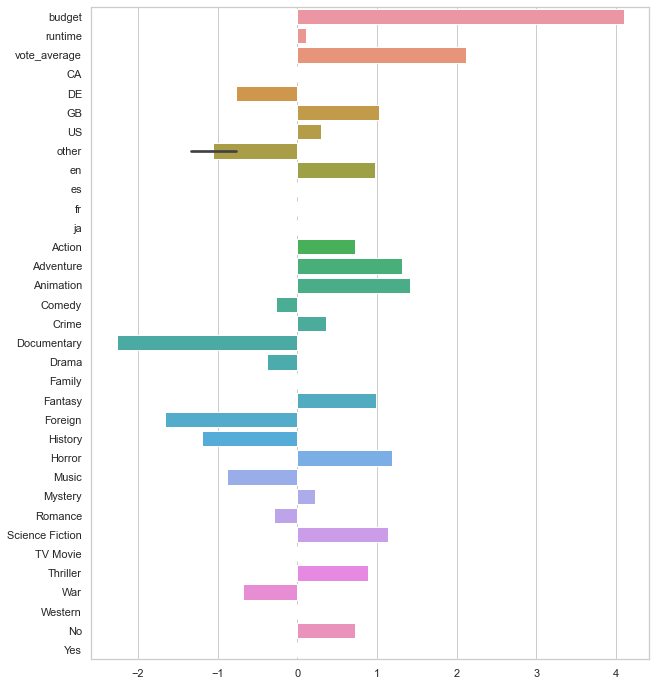

In [173]:
# coefficient of lasso regression
plt.figure(figsize=(10,12))
sns.barplot(y=X.columns, x = lasso_best.coef_)

In [183]:

from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, lasso_best.predict(test_X))

186.55588266672896

In [185]:
print('R squared test set', round(lasso_best.score(test_X, test_y), 2))

R squared test set 0.16


(0.0033063242866974273,
 6.596984250313736,
 26.044919854984386,
 346.471477657865)

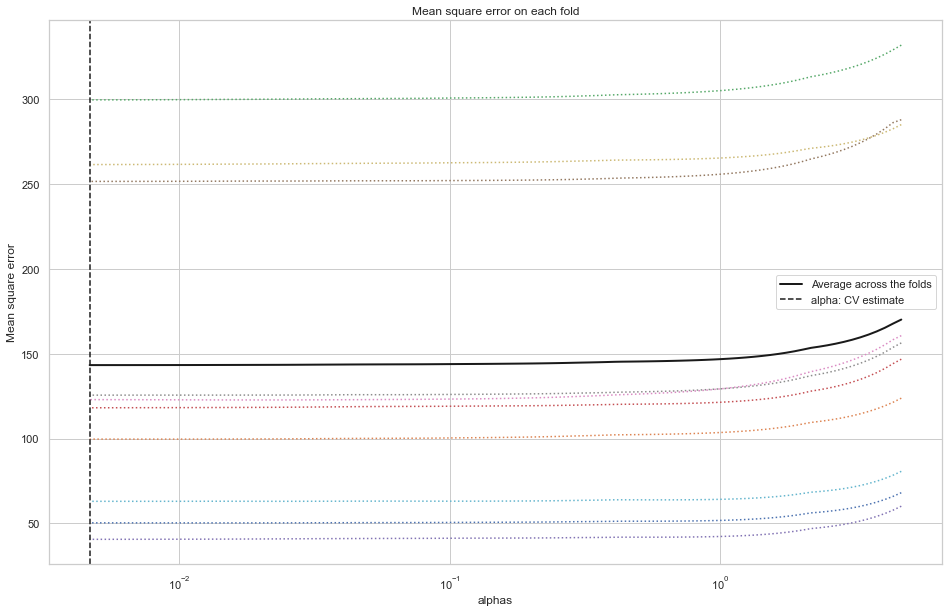

In [80]:

# lasso regression MSE plot
fig, ax = plt.subplots(figsize=(16, 10))
plt.semilogx(lasscv.alphas_, lasscv.mse_path_, ":")
plt.plot(
    lasscv.alphas_ ,
    lasscv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasscv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 50000, 250000
# plt.ylim(ymin, ymax);

### Model 2

In [81]:
##module 2 .To some extent, the rating of audience has a strong influence on the revenue or the popularity of a movie. Therefore, we plan to make a regression model to predict the rating of voting by observer.
movies2 = movies_meta[movies_meta['vote_count'] >= 10]
movies2 = movies2[movies2['budget'] > 100]
movies2 = movies2[movies2['runtime'] != 0]
movies2
movies2.describe(include=['object'])

,adult,id,imdb_id,original_language,original_title,country,status,title,video,gain,genres,month,year,isen
count,19073,19073,19073,19073,19073,19073,19073,19073,19073,19073,19073,19073,19073,19073
unique,2,7480,7480,47,7322,76,3,7300,2,3,20,12,103,2
top,False,10991,tt0235679,en,Alice in Wonderland,US,Released,Alice in Wonderland,False,True,Drama,09,2011,Yes
freq,19070,10,10,16585,11,11572,19059,11,19068,9531,3512,2080,888,16585


In [82]:
movies2.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,profit,roi,release_month
count,1.907300e+04,19073.000000,1.907300e+04,19073.000000,19073.000000,19073.000000,1.907300e+04,1.907300e+04,19073.000000
mean,2.886809e+07,9.095508,7.491094e+07,108.396745,6.172144,615.693965,4.914940e+07,2.727967e+02,6.841713
std,3.956114e+07,13.656861,1.626751e+08,27.425073,0.944801,1194.004645,1.347778e+08,1.649141e+04,3.427683
min,1.070000e+02,0.000308,0.000000e+00,4.000000,0.000000,10.000000,-1.657101e+08,-9.999995e-01,1.000000
25%,4.000000e+06,4.431577,0.000000e+00,93.000000,5.600000,47.000000,0.000000e+00,0.000000e+00,4.000000
50%,1.400000e+07,7.718723,1.282781e+07,104.000000,6.200000,171.000000,0.000000e+00,0.000000e+00,7.000000
75%,3.500000e+07,11.185625,7.243644e+07,118.000000,6.800000,597.000000,4.020000e+07,2.005403e+00,10.000000
max,3.800000e+08,547.488298,2.787965e+09,705.000000,9.100000,14075.000000,2.550965e+09,1.018618e+06,12.000000


In [83]:
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
X = movies2[['budget','profit','runtime','vote_count','month','original_language','country','year','revenue','genres','status']]
X= pd.get_dummies(X,prefix='',prefix_sep='')
Y = movies2[['vote_average']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.4,random_state=0)

In [86]:
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)

In [87]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     31.68
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:42:40   Log-Likelihood:                -12563.
No. Observations:               11443   AIC:                         2.563e+04
Df Residuals:                   11193   BIC:                         2.746e+04
Df Model:                         249                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
budget          -1.306e-08   7.94e-10    -16.451      0.000   -1.46e-08   -1.15e-08
profit          -9.824e-09   7.79e-10    -12.609      0.000   -1.14e-08    -8.3e-09
runtime             0.0069      0.000     22.966      0.000       0.006       0.007
vote_count          0.0004    9.6e-06     39.917      0.000       0.000       0.000
revenue          9.435e-09    7.7e-10     12.261      0.000    7.93e-09    1.09e-08
01                  0.9394      0.044     21.464      0.000       0.854       1.025
02                  1.0348      0.044     23.428      0.000       0.948       1.121
03                  1.0478      0.043     24.584      0.000       0.964       1.131
04                  1.0172      0.043     23.839      0.000       0.934       1.101
05                  1.0907      0.043     25.498      0.000       1.007       1.175
06                  1.0072      0.043     23.496      0.000       0.923       1.091
07                  1.0139      0.043     23.828      0.000       0.930       1.097
08                  1.0251      0.042     24.314      0.000       0.943       1.108
09                  1.1931      0.041     28.797      0.000       1.112       1.274
10                  1.0360      0.042     24.843      0.000       0.954       1.118
11                  1.0363      0.042     24.556      0.000       0.954       1.119
12                  1.1691      0.042     27.931      0.000       1.087       1.251
af                  0.4831      0.538      0.898      0.369      -0.572       1.538
ar                  0.2609      0.258      1.009      0.313      -0.246       0.767
bo                  0.7367      0.432      1.705      0.088      -0.110       1.584
bs                  0.6369      0.522      1.221      0.222      -0.386       1.659
ca                  0.5266      0.726      0.726      0.468      -0.896       1.950
cn                  0.1035      0.149      0.692      0.489      -0.189       0.396
cs                  0.1033      0.724      0.143      0.887      -1.317       1.523
da                  0.2676      0.168      1.593      0.111      -0.062       0.597
de                  0.0147      0.112      0.132      0.895      -0.204       0.233
el                 -2.0669      0.849     -2.436      0.015      -3.730      -0.404
en                 -0.3152      0.069     -4.537      0.000      -0.451      -0.179
es                  0.2181      0.111      1.965      0.049       0.001       0.436
et                  1.0731      0.706      1.519      0.129      -0.311       2.458
fa                  0.5219      0.153      3.403      0.001       0.221       0.822
fi                  0.2570      0.260      0.989      0.323      -0.253       0.766
fr                  0.1163      0.086      1.350      0.177      -0.053       0.285
he                 -0.4429      0.275     -1.609      0.108

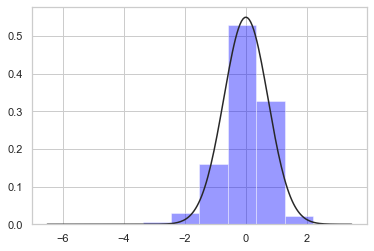

In [88]:
from scipy import stats
residual = results.resid
sns.distplot(residual,
bins = 10,
kde = False,
color = 'blue',
fit = stats.norm)
plt.show()

In [89]:
Tm1 = DecisionTreeRegressor(max_depth=5)
Tm2 = DecisionTreeRegressor(max_depth=44)
model1 = Tm1.fit(X_train,y_train)
model2 = Tm2.fit(X_train,y_train)
print(model1.score(X_test,y_test))
print(model2.score(X_test,y_test))

0.32544466740240285
0.6107560999200277


In [90]:
GBTm = GradientBoostingRegressor(random_state=0)
model5 = GBTm.fit(X_train,y_train)
print(model5.score(X_test,y_test))

C:\JetBrains\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4820231138675305


In [186]:
RTm1 = RandomForestRegressor(n_estimators=30,random_state=0)
RTm2 = RandomForestRegressor(n_estimators=90,random_state=0)
model3 = RTm1.fit(X_train,y_train)
model4 = RTm2.fit(X_train,y_train)
print(model3.score(X_test,y_test))
print(model4.score(X_test,y_test))

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.7473422875733761
0.7553908800326681


### Model 3 Decision Tree

In [187]:
# import Statsmodel 
# stats.summary(lasso_best, test_X, test_y)

In [188]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
import scipy.stats as stats

In [189]:
# Outliers of ROI removing
z = np.abs(stats.zscore(movies_meta['roi']))
movies_meta_class = movies_meta[(z<3)]
movies_meta_class.shape

(93448, 14)

In [190]:
movies_meta_class = movies_meta_class[movies_meta_class['gain'] != 'unknown']
movies_meta_class = movies_meta_class[movies_meta_class['budget'] != 0]
movies_meta_class = movies_meta_class[movies_meta_class['budget'] > 1000]
movies_meta_class = movies_meta_class[movies_meta_class['country'] != 'unknown']
movies_meta_class = movies_meta_class[['country','genres','original_language','budget','gain','roi']]
movies_meta_class.reset_index(drop=True, inplace=True)


In [191]:
movies_meta_class['roi_level'] = '0'
third_quant = np.quantile(movies_meta_class['roi'], 0.95)
for i in range(movies_meta_class.shape[0]):
    if movies_meta_class['roi'][i] >= third_quant:
        movies_meta_class['roi_level'][i] = 'High'

    elif movies_meta_class['roi'][i] > 0 and movies_meta_class['roi'][i] < third_quant:
        movies_meta_class['roi_level'][i] = 'Low'

    else: movies_meta_class['roi_level'][i] = 'Negative'

C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [192]:


main_lang = ('en','ja','fr','es')
for i in range(movies_meta_class.shape[0]):
    if movies_meta_class['original_language'][i] not in main_lang:
        movies_meta_class['original_language'][i] = 'other'

lan = {'en': 0, 'ja': 1, 'fr': 2, 'es': 3, 'other': 4}
movies_meta_class['original_language'] = movies_meta_class['original_language'].map(lan)

main_con = ('US','GB','CA','DE')
for i in range(movies_meta_class.shape[0]):
    if movies_meta_class['country'][i] not in main_con:
        movies_meta_class['country'][i] = 'other'

con = {'US': 0, 'GB': 1, 'CA': 2, 'DE': 3, 'other': 4}
movies_meta_class['country'] = movies_meta_class['country'].map(con)

main_gen = ('Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Science Fiction','Crime','Family','Fantasy' )
for i in range(movies_meta_class.shape[0]):
    if movies_meta_class['genres'][i] not in main_con:
        movies_meta_class['genres'][i] = 'other'

gen = {'Drama': 0, 'Comedy': 1, 'Thriller': 3, 'Action': 2, 'Romance': 5, 'Adventure': 4, 'Science Fiction': 6,
 'Crime': 7, 'Family': 8, 'Fantasy': 9, 'other': 10 }
movies_meta_class['genres'] = movies_meta_class['genres'].map(gen)
          
# r = {'High': 0, 'Middle': 1, 'Negative': 2}
# movies_meta_class['roi_level'] = movies_meta_class['roi_level'].map(r).astype('str')


C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [193]:
movies_meta_class['roi_level'].value_counts()

Negative    9826
Low         3221
High         687
Name: roi_level, dtype: int64

In [194]:
movies_meta_class.fillna(0)
feature_cols = ['country', 'original_language', 'budget','genres']
X = movies_meta_class[feature_cols] # Features
y = movies_meta_class.roi_level # Target variable

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [196]:
clf = DecisionTreeClassifier(max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [197]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.71536034942975


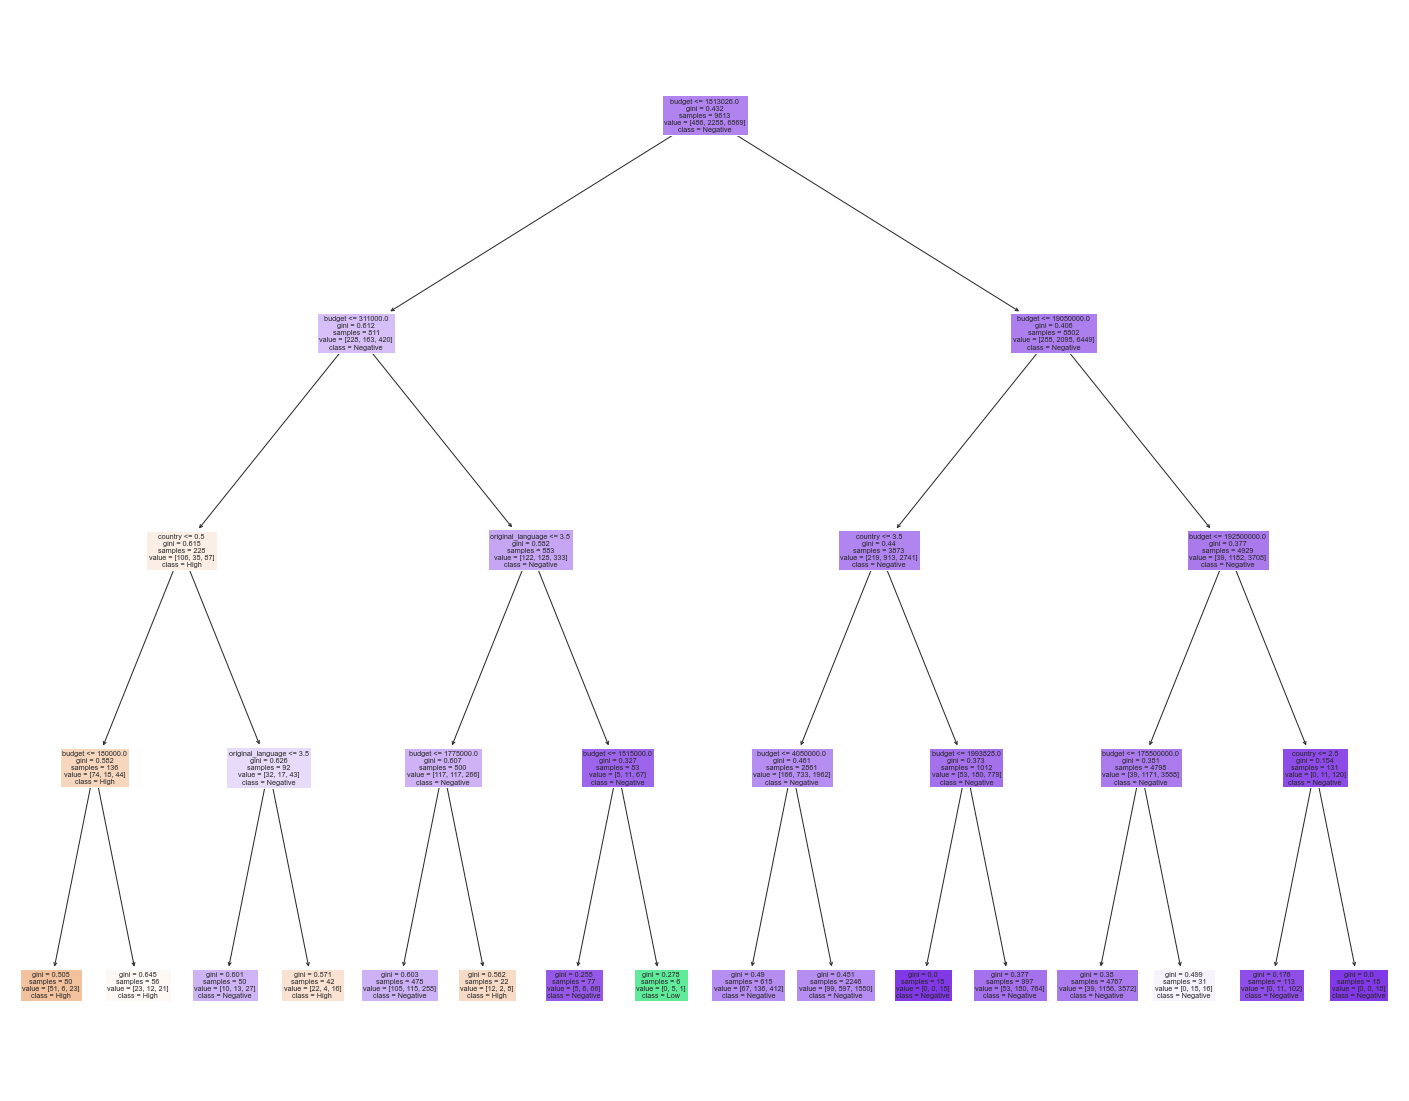

In [198]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,feature_names=feature_cols,class_names=clf.classes_,filled=True)